In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

C:\Users\vicen\Anaconda3\envs\data_mining\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [13]:
df_og = pd.read_csv('medium_data.csv', sep=',', index_col=0)

In [17]:
df_copyog = df_og.copy()

In [19]:
#columns_to_drop = ['message', 'Date', 'Subject', 'Date_datetime', 'Day_of_week', 'message_length']
columns_to_drop = ['message', 'Date', 'Subject', 'Date_datetime']
df_copyog = df_copyog.drop(columns=columns_to_drop)

df_copyog.head()

,Message-Body,Day_of_week,X-Folder-split,message_length
0,here is our forecast\n\n,Mon,'sent mail,23
1,traveling to have a business meeting takes the...,Fri,'sent mail,786
2,test successful. way to go!!!,Wed,'sent mail,30
3,"randy,\n\n can you send me a schedule of the s...",Mon,'sent mail,187
4,let's shoot for tuesday at 11:45.,Thu,'sent mail,35


In [20]:
df_copyog.rename(columns={'X-Folder-split':'original_subj',
                         'Message-Body':'message'}, inplace=True) 

In [21]:
labeling = pd.read_csv('labeling.csv', index_col=0)

In [22]:
df_copyog = pd.merge(df_copyog, labeling, on='original_subj')

In [23]:
df_copyog['message'].apply(lambda x: len(x.split(' '))).sum()

156709129

In [24]:
df_copyog['label'].value_counts()

1     420184
2      68076
3      11257
5       3584
7       3521
4       3248
0       2457
10      1928
8       1868
6        786
9        492
Name: label, dtype: int64

In [25]:
df_copyog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517401 entries, 0 to 517400
Data columns (total 6 columns):
message           517401 non-null object
Day_of_week       517401 non-null object
original_subj     517401 non-null object
message_length    517401 non-null int64
subject           475168 non-null object
label             517401 non-null int64
dtypes: int64(2), object(4)
memory usage: 27.6+ MB


In [26]:
df_copyog["label"] = df_copyog["label"].astype('category')

In [27]:
df_copyog.head()

,message,Day_of_week,original_subj,message_length,subject,label
0,here is our forecast\n\n,Mon,'sent mail,23,sent,1
1,traveling to have a business meeting takes the...,Fri,'sent mail,786,sent,1
2,test successful. way to go!!!,Wed,'sent mail,30,sent,1
3,"randy,\n\n can you send me a schedule of the s...",Mon,'sent mail,187,sent,1
4,let's shoot for tuesday at 11:45.,Thu,'sent mail,35,sent,1


In [28]:
df_copyog.to_csv('message_length.csv', sep=',')

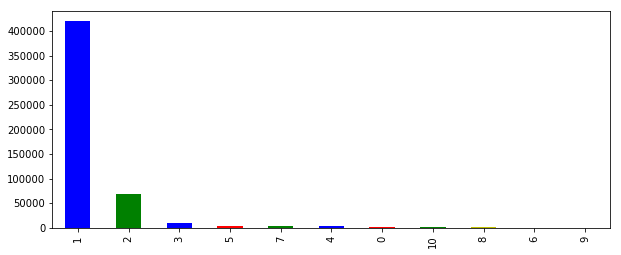

In [11]:
# Change the tags to the clustering results
my_tags = ['0','1','2','3','4','5','6','7','8','9','10']
plt.figure(figsize=(10,4))
df_copyog.label.value_counts().plot(kind='bar', color=['b', 'g', 'b', 'r', 'g', 'b', 'r','g','y','r','b','g']);

In [12]:
def print_plot(index, df):
    example = df[df.index == index][['message', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [13]:
print_plot(5, df_copyog)

greg,

 how about either next tuesday or thursday?

phillip
Tag: 1


In [14]:
X = df_copyog['message']
y = df_copyog['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Doc2vec and Logistic Regression

In [22]:
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [27]:
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_copyog.message, df_copyog.label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [29]:
all_data[:2]

[TaggedDocument(words=['good!!', 'i', 'like', 'it!', '-----original', 'message-----', 'from:', 'maggi,', 'mike', 'sent:', 'monday,', 'february', '04,', '2002', '10:12', 'am', 'to:', 'rybarski,', 'amanda', 'subject:', 're:', 'youre', 'in', 'trouble', '-----original', 'message-----', 'from:', 'rybarski,', 'amanda', 'sent:', 'monday,', 'february', '04,', '2002', '10:09', 'am', 'to:', 'maggi,', 'mike', 'subject:', 're:', 'thank', 'you!', '-----original', 'message-----', 'from:', 'maggi,', 'mike', 'sent:', 'monday,', 'february', '04,', '2002', '10:09', 'am', 'to:', 'rybarski,', 'amanda', 'subject:', 're:', 'it', 'looks', 'great', '-----original', 'message-----', 'from:', 'rybarski,', 'amanda', 'sent:', 'monday,', 'february', '04,', '2002', '10:09', 'am', 'to:', 'maggi,', 'mike', 'subject:', 're:', 'i', 'got', 'a', 'new', 'haircut!', '-----original', 'message-----', 'from:', 'maggi,', 'mike', 'sent:', 'monday,', 'february', '04,', '2002', '10:09', 'am', 'to:', 'rybarski,', 'amanda', 'subject

In [ ]:
model = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=2, alpha=0.065, min_alpha=0.065)
model.build_vocab([x for x in tqdm(all_data)])

100%|█████████████████████████████████████████████████████████████████████| 517401/517401 [00:00<00:00, 2466490.90it/s]


# THE MODEL FRAMEWORK COULD NOT BE TESTED FURTHER SINCE DOC2VEC REQUIRES LARGE AMOUNTS OF MEMORY!!

In [ ]:
def vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors = vectors(model, len(X_train), 300, 'Train')
test_vectors = vectors(model, len(X_test), 300, 'Test')

In [ ]:
log_reg = LogisticRegression(n_jobs=1, C=1e5)
log_reg.fit(train_vectors, y_train)

In [ ]:
log_reg = log_reg.fit(train_vectors, y_train)
y_pred = log_reg.predict(test_vectors)